In [1]:
from astropy.convolution import convolve, convolve_fft, Gaussian2DKernel
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy import io

In [2]:
def beautification():
    ax.set_facecolor('whitesmoke')
    ax.patch.set_alpha(.5)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.minorticks_on()
    ax.tick_params('both', length=8, which='major', labelsize='10')
    ax.tick_params('both',length=3, which='minor')
    ax.grid(True, which='major', ls='dashed', alpha=.5)
    ax.grid(True, which='minor', ls='dashed', alpha=.15)
    ax.legend(loc='best')

In [3]:
def framer(RA,DEC):
    min_max = [[min(RA), max(RA)], [min(DEC), max(DEC)]]
    ranges = [max(RA)-min(RA),max(DEC)-min(DEC)]
    for i, irange in enumerate(ranges):
        if irange == max(ranges):
            delta = irange - ranges[abs(i-1)]
            min_max[abs(i-1)][0] -= delta / 2.0
            min_max[abs(i-1)][1] += delta / 2.0
    return min_max

In [4]:
def pixelate(RA, DEC, FLUX, n_bins):

    min_max = framer(RA, DEC)
    RA_zoom, DEC_zoom = min_max[0], min_max[1]

    bin_size = (RA_zoom[1] - RA_zoom[0]) / n_bins
    RA_bins = (np.array(range(n_bins)) * bin_size) + RA_zoom[0]
    DEC_bins = (np.array(range(n_bins)) * bin_size) + DEC_zoom[0]

    pixels = np.zeros((len(RA_bins), len(DEC_bins)))
    RA_histogram = np.digitize(np.array(RA), RA_bins)

    for bin_i in range(len(RA_bins) - 2):
        RA_inds = np.where(RA_histogram == bin_i)
        if len(RA_inds[0]) == 0:
            continue
        DEC_histogram = np.digitize(np.array(DEC)[RA_inds], DEC_bins)
        for bin_j in range(len(DEC_bins) - 2):
            DEC_inds = np.where(DEC_histogram == bin_j)
            if len(DEC_inds[0]) == 0:
                continue
            pixels[bin_i, bin_j] = np.sum(FLUX[RA_inds[0][DEC_inds][0]])

    RA_pixel_centers = (np.arange(n_bins) * bin_size) + RA_zoom[0] + bin_size / 2.
    DEC_pixel_centers = (np.arange(n_bins) * bin_size) + DEC_zoom[0] + bin_size / 2.
    return pixels, RA_pixel_centers, DEC_pixel_centers

In [5]:
def pandize(data):
    df_init = pd.DataFrame.from_dict({(i): data['data']['source_array'][i]
                                      for i in data['data']['source_array'][0].dtype.names},
                                     orient='index').unstack().unstack()

    pt_df_init = df_init[df_init['EXTEND'].isnull()]
    ext_df_init = df_init[df_init['EXTEND'].notnull()]

    restructured_pt = {(pt_df_init.iloc[i]['ID']): 
                        {(0):
                         {(j):
                          pt_df_init.iloc[i][j]
                          for j in pt_df_init.columns}
                         }
                        for i in range(len(pt_df_init))}
    restructured_pt_flux = {(pt_df_init.iloc[i]['ID']): 
                            {(0):
                             {(j):
                              pt_df_init.FLUX.iloc[i][j][0]
                              for j in pt_df_init.FLUX.iloc[i].dtype.names}
                            }
                            for i in range(len(pt_df_init))}

    restructured_ext = {(ext_df_init.iloc[i]['EXTEND']['ID'][0]): 
                        {(k):
                         {(j):
                          ext_df_init.iloc[i]['EXTEND'][j][k]
                          for j in ext_df_init.iloc[i]['EXTEND'].dtype.names}
                         for k in range(len(ext_df_init.iloc[i]['EXTEND']['ID']))}
                        for i in range(len(ext_df_init))}
    restructured_ext_flux = {(ext_df_init.iloc[i]['EXTEND']['ID'][0]): 
                             {(k):
                              {(j):
                               ext_df_init.iloc[i]['EXTEND'].FLUX[k][j][0]
                               for j in ext_df_init.iloc[i].EXTEND.FLUX[0].dtype.names}
                              for k in range(len(ext_df_init.iloc[i].EXTEND.FLUX))}
                             for i in range(len(ext_df_init))}
    restructured_ext_avg = {(ext_df_init.iloc[i]['ID']): 
                        {(0):
                         {(j):
                          ext_df_init.iloc[i][j]
                          for j in ext_df_init.columns}
                         }
                        for i in range(len(ext_df_init))}

    restructured_ext_flux_avg = {(ext_df_init.iloc[i]['ID']): 
                            {(0):
                             {(j):
                              ext_df_init.FLUX.iloc[i][j][0]
                              for j in ext_df_init.FLUX.iloc[i].dtype.names}
                            }
                            for i in range(len(ext_df_init))}
    pt_df = pd.DataFrame.from_dict({(i,j): restructured_pt[i][j] 
                                 for i in restructured_pt.keys() 
                                 for j in restructured_pt[i].keys()},
                                orient='index').drop('FLUX', axis=1)
    pt_df.index.names = ['objid','component']
    pt_df = pd.concat({"Source": pt_df}, axis=1)

    pt_flux_df = pd.DataFrame.from_dict({(i,j): restructured_pt_flux[i][j] 
                                         for i in restructured_pt_flux.keys() 
                                         for j in restructured_pt_flux[i].keys()},
                                        orient='index')
    pt_flux_df.index.names = ['objid','component']
    pt_flux_df = pd.concat({"Flux": pt_flux_df}, axis=1)
    pt_df = pt_df.merge(pt_flux_df, left_index=True, right_index=True)

    ext_df = pd.DataFrame.from_dict({(i,j): restructured_ext[i][j] 
                                     for i in restructured_ext.keys() 
                                     for j in restructured_ext[i].keys()},
                                    orient='index').drop('FLUX', axis=1)
    ext_df.index.names = ['objid','component']
    ext_df = pd.concat({"Source": ext_df}, axis=1)

    ext_flux_df = pd.DataFrame.from_dict({(i,j): restructured_ext_flux[i][j] 
                                     for i in restructured_ext_flux.keys() 
                                     for j in restructured_ext_flux[i].keys()},
                                    orient='index')
    ext_flux_df.index.names = ['objid','component']
    ext_flux_df = pd.concat({"Flux": ext_flux_df}, axis=1)
    ext_df = ext_df.merge(ext_flux_df, left_index=True, right_index=True)

    ext_df_avg = pd.DataFrame.from_dict({(i,j): restructured_ext_avg[i][j] 
                                     for i in restructured_ext_avg.keys() 
                                     for j in restructured_ext_avg[i].keys()},
                                    orient='index').drop('FLUX', axis=1).drop('EXTEND', axis=1)
    ext_df_avg.index.names = ['objid','component']
    ext_df_avg = pd.concat({"Source": ext_df_avg}, axis=1)

    ext_flux_df_avg = pd.DataFrame.from_dict({(i,j): restructured_ext_flux_avg[i][j] 
                                     for i in restructured_ext_flux_avg.keys() 
                                     for j in restructured_ext_flux_avg[i].keys()},
                                    orient='index')
    ext_flux_df_avg.index.names = ['objid','component']
    ext_flux_df_avg = pd.concat({"Flux": ext_flux_df_avg}, axis=1)
    ext_df_avg = ext_df_avg.merge(ext_flux_df_avg, left_index=True, right_index=True)


    all_df = pt_df.append(ext_df).sort_index(axis=0)
    return pt_df, ext_df, ext_df_avg, all_df

In [6]:
data = {'data': scipy.io.readsav('1131709192_source_array.sav', python_dict=True)}

In [12]:
print data['data']['source_array'][2]

(29760, 1257.341796875, 1107.1663818359375, 343.2740478515625, -40.9604606628418, 582.5723876953125, 182.4350128173828, -0.8000001311302185, 1.0, 0, None, rec.array([( 3.52244115,  3.64581394,  0.+0.j,  0.+0.j,  23.9213829,  0.,  0.,  0.)], 
          dtype=[(('xx', 'XX'), '>f4'), (('yy', 'YY'), '>f4'), (('xy', 'XY'), '>c8'), (('yx', 'YX'), '>c8'), (('i', 'I'), '>f4'), (('q', 'Q'), '>f4'), (('u', 'U'), '>f4'), (('v', 'V'), '>f4')]))


In [15]:
pt_df, ext_df, ext_df_avg, all_df = pandize(data)

In [23]:
test_df = ext_df.head(5)
test_df.ix[(2932,5),:] = 0
test_df

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Source                                                      \
                EXTEND FLAG STON          RA ALPHA           Y           X   
objid component                                                              
29762 0           None  0.0  0.0  299.583313  -0.8  841.461365  778.750488   
      1           None  0.0  0.0  299.583649  -0.8  841.461609  778.753540   
      2           None  0.0  0.0  299.584015  -0.8  841.461548  778.756714   
      3           None  0.0  0.0  299.584351  -0.8  841.460876  778.760193   
      4           None  0.0  0.0  299.584717  -0.8  841.460754  778.763611   
2932  5              0  0.0  0.0    0.000000   0.0    0.000000    0.000000   

                                                     Flux                      \
                       FREQ        DEC       ID GAIN    Q         I        YY   
objid component                                                                 
29762 0          182.435013 -55.168739  29762.0  0.1  0.0  1.598767  0.069969   
      1          182.435013 -55.168774  29762.0  0.1  0.0  1.449283  0.063427   
      2          182.435013 -55.168827  29762.0  0.1  0.0  1.314052  0.057508   
      3          182.435013 -55.168919  29762.0  0.1  0.0  1.189305  0.052049   
      4          182.435013 -55.168980  29762.0  0.1  0.0  1.077861  0.047172   
2932  5            0.000000   0.000000      0.0  0.0  0.0  0.000000  0.000000   

                                             
                 YX        XX  XY    U    V  
objid component                              
29762 0          0j  0.079008  0j  0.0  0.0  
      1          0j  0.071620  0j  0.0  0.0  
      2          0j  0.064938  0j  0.0  0.0  
      3          0j  0.058773  0j  0.0  0.0  
      4          0j  0.053265  0j  0.0  0.0  
2932  5          0j  0.000000  0j  0.0  0.0

In [15]:
ext_objids = list(set(ext_df.index.get_level_values('objid')))

In [19]:
ext_bright = list(set(ext_df_avg[ext_df_avg.Flux.I>5].index.get_level_values('objid')))

In [8]:
ext_bright

NameError: name 'ext_bright' is not defined

In [42]:
RA = np.array([i for i in ext_df.loc[29762].Source.RA])
DEC = np.array([i for i in ext_df.loc[29762].Source.DEC])a
FLUX = np.array([i for i in ext_df.loc[29762].Flux.I])
n_bins = 200
pixels, RA_pixel_centers, DEC_pixel_centers = pixelate(RA, DEC, FLUX, n_bins)

sigmawidth = 25
binwidth = 3
pixelreplacement = 1e-25
sigmawidth = sigmawidth * (1. / 3600.)
binwidth = binwidth * (1. / 3600.)
kernel = Gaussian2DKernel(stddev=(sigmawidth / binwidth))

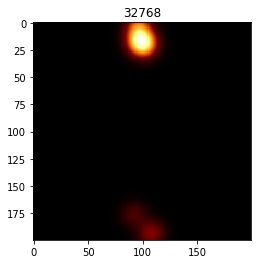

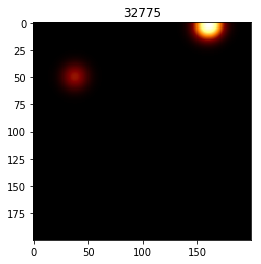

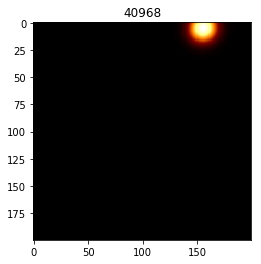

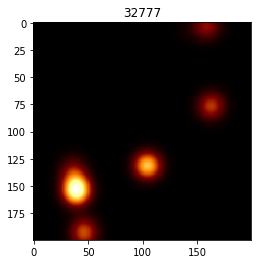

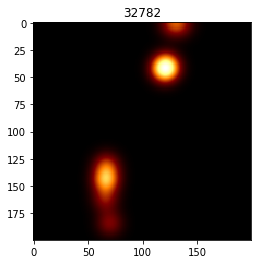

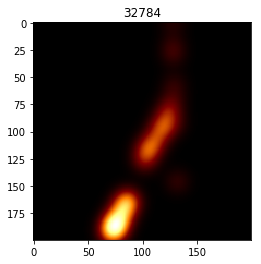

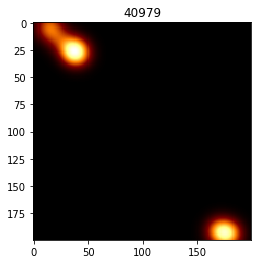

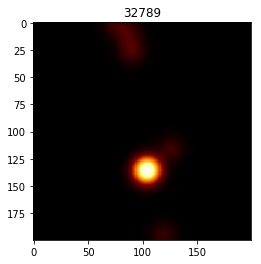

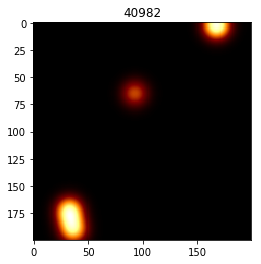

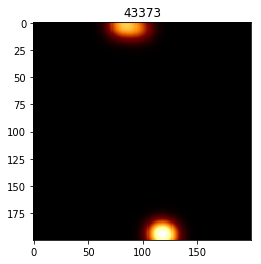

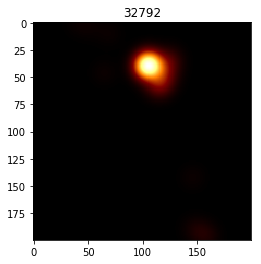

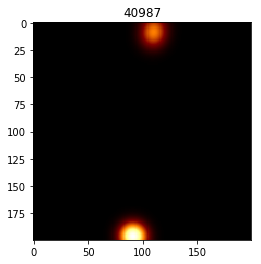

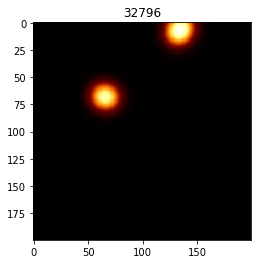

In [43]:
for objid in range(len(ext_bright)):
    RA = [i for i in ext_df.loc[ext_objids[objid]].Source.RA]
    DEC = [i for i in ext_df.loc[ext_objids[objid]].Source.DEC]
    FLUX = [i for i in ext_df.loc[ext_objids[objid]].Flux.I]
    pixels, RA_pixel_centers, DEC_pixel_centers = pixelate(RA, DEC, FLUX, n_bins)
    pixels[pixels == 0] = pixelreplacement
    convolved_pixels = convolve(pixels, kernel)

    plt.imshow(convolved_pixels, cmap='afmhot')
    plt.title('{}'.format(ext_objids[objid]))
    plt.show()

In [ ]:
ext_df_avg

In [ ]:
all_df.Flux.head()

In [ ]:
all_df.head()

In [ ]:
ext_df.loc[29873]

In [ ]:
height_ratios = [4]
width_ratios = [4,4,4]
wspace = 0
hspace = 1
fig = plt.figure(figsize=(sum(width_ratios) + wspace * (len(width_ratios) - 1),
                          sum(height_ratios) + hspace * (len(height_ratios) - 1)))
gs = gridspec.GridSpec(len(height_ratios), len(width_ratios), height_ratios=height_ratios, width_ratios=width_ratios)
fig.suptitle('objid', fontsize=20)

ax = fig.add_subplot(gs[0, 0])
ax.hist2d(all_df.Source.RA,all_df.Source.DEC, bins=300)
beautification()

ax = fig.add_subplot(gs[0, 1])
ax.hist2d(all_df.Source.RA,all_df.Source.DEC, bins=300)
beautification()

ax = fig.add_subplot(gs[0, 2])
ax.hist2d(ext_df.loc[29873].Source.RA,ext_df.loc[29873].Source.DEC)
beautification()

plt.show()

In [ ]:
ext_df.loc[ext_df.Flux.I==max(ext_df.Flux.I)]

In [ ]:
plt.scatter(ext_df.RA,ext_df.DEC,c='maroon',s=.01)
plt.scatter(pt_df.RA,pt_df.DEC,c='wheat',s=.01)
plt.show()

In [ ]:

plt.scatter(all_df.RA,all_df.DEC,s=.01)
plt.show()

In [ ]:
ext_objids = list(set(ext_df.index.get_level_values('objid')))
for i in ext_objids:
    plt.scatter(ext_df.loc[i].RA,ext_df.loc[i].DEC,s=.5)
    plt.show()

In [ ]:
{(j): i 
 for j in extend_df.iloc[0]['EXTEND'].dtype.names
for i in extend_df.iloc[0]['EXTEND'][j]}

In [ ]:
df.loc[29762].head(2)

In [ ]:
user_dict = {12: {'Category 1': {'att_1': 1, 'att_2': 'whatever'},
                  'Category 2': {'att_1': 23, 'att_2': 'another'}},
             15: {'Category 1': {'att_1': 10, 'att_2': 'foo'},
                  'Category 2': {'att_1': 30, 'att_2': 'bar'}}}

df = pd.DataFrame.from_dict({(i,j): user_dict[i][j] 
                             for i in user_dict.keys() 
                             for j in user_dict[i].keys()},
                            orient='index')